In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns
import requests
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from datetime import datetime
sns.set_theme(style="darkgrid")

In [20]:
def api_req(url,params):
    response = requests.get(url, params=params)
    # Parse response
    data = response.json()['Data']['Data']
    df = pd.DataFrame(data)
    df['timestamp'] = pd.to_datetime(df['time'], unit='s')
    df = df.sort_values(by='timestamp',ascending=False)
    df.drop(df.head(1).index,inplace=True)
    return df

In [24]:
# Only run this cell if updating the model with new data
url = 'https://min-api.cryptocompare.com/data/v2/histoday'
params = {
    'api_key':'4f5cd6a090d066496f7a74d6a33ef6913ef96807d2d33f5c47e50f7b011bf2be',
    'fsym': 'BTC',
    'tsym': 'USD',
    'limit': 1999 # Get data for the past year
}
df = api_req(url,params)
df.head()

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,timestamp
1998,1680566400,28437.75,27674.33,27810.08,33855.00,9.519132e+08,28178.13,direct,,2023-04-04
1997,1680480000,28494.64,27290.26,28186.76,52416.66,1.467725e+09,27810.08,direct,,2023-04-03
1996,1680393600,28538.36,27880.95,28465.30,21016.25,5.925811e+08,28186.76,direct,,2023-04-02
1995,1680307200,28810.95,28265.42,28477.29,19774.03,5.632994e+08,28465.30,direct,,2023-04-01
1994,1680220800,28650.47,27541.23,28037.46,50916.39,1.436740e+09,28477.29,direct,,2023-03-31


In [26]:
# Only run this cell if training from price data in csv file
df = pd.read_csv('btc-daily-price.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,timestamp
0,1680566400,28437.75,27674.33,27810.08,33855.00,9.519132e+08,28178.13,direct,NaN,2023-04-04
1,1680480000,28494.64,27290.26,28186.76,52416.66,1.467725e+09,27810.08,direct,NaN,2023-04-03
2,1680393600,28538.36,27880.95,28465.30,21016.25,5.925811e+08,28186.76,direct,NaN,2023-04-02
3,1680307200,28810.95,28265.42,28477.29,19774.03,5.632994e+08,28465.30,direct,NaN,2023-04-01
4,1680220800,28650.47,27541.23,28037.46,50916.39,1.436740e+09,28477.29,direct,NaN,2023-03-31
...,...,...,...,...,...,...,...,...,...,...
1994,1508284800,5601.30,5114.87,5598.58,122020.31,6.547225e+08,5575.83,direct,NaN,2017-10-18
1995,1508198400,5773.32,5521.09,5759.25,65637.43,3.686583e+08,5598.58,direct,NaN,2017-10-17
1996,1508112000,5795.33,5576.10,5677.35,61358.95,3.491547e+08,5759.33,direct,NaN,2017-10-16
1997,1508025600,5862.69,5448.22,5824.71,101636.95,5.711662e+08,5688.14,direct,NaN,2017-10-15


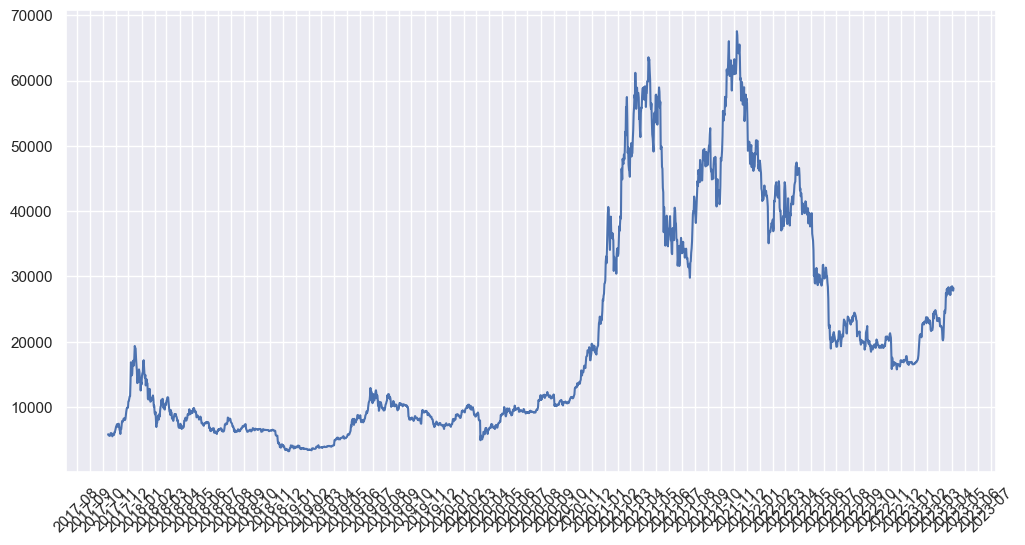

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df['timestamp'], df['close'])
# format the x axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# set the tick locator to show ticks at the start of each month
ax.xaxis.set_major_locator(mdates.MonthLocator())

# set the tick labels to show only the month and year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# set the rotation of the tick labels
plt.xticks(rotation=45)
plt.show()

In [28]:
# clean data for modelling
df = df[['timestamp', 'close']]
df.columns = ['ds', 'y']
df = df.dropna()

In [29]:
df.head()

,ds,y
0,2023-04-04,28178.13
1,2023-04-03,27810.08
2,2023-04-02,28186.76
3,2023-04-01,28465.30
4,2023-03-31,28477.29


In [30]:
model = Prophet()
model.fit(df)

09:40:37 - cmdstanpy - INFO - Chain [1] start processing
09:40:38 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
future = model.make_future_dataframe(periods=7)
future.tail(7)

,ds
1999,2023-04-05
2000,2023-04-06
2001,2023-04-07
2002,2023-04-08
2003,2023-04-09
2004,2023-04-10
2005,2023-04-11


In [35]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
1999,2023-04-05,18221.230439,12148.613515,24007.199048
2000,2023-04-06,17906.719715,11659.610646,23667.435061
2001,2023-04-07,17683.722359,12136.784112,23586.379300
2002,2023-04-08,17453.579356,11721.405054,23401.059329
2003,2023-04-09,17201.355152,11418.881123,23214.424240
2004,2023-04-10,16981.687564,10665.378959,22416.817286
2005,2023-04-11,16716.606141,11094.530410,22173.707599


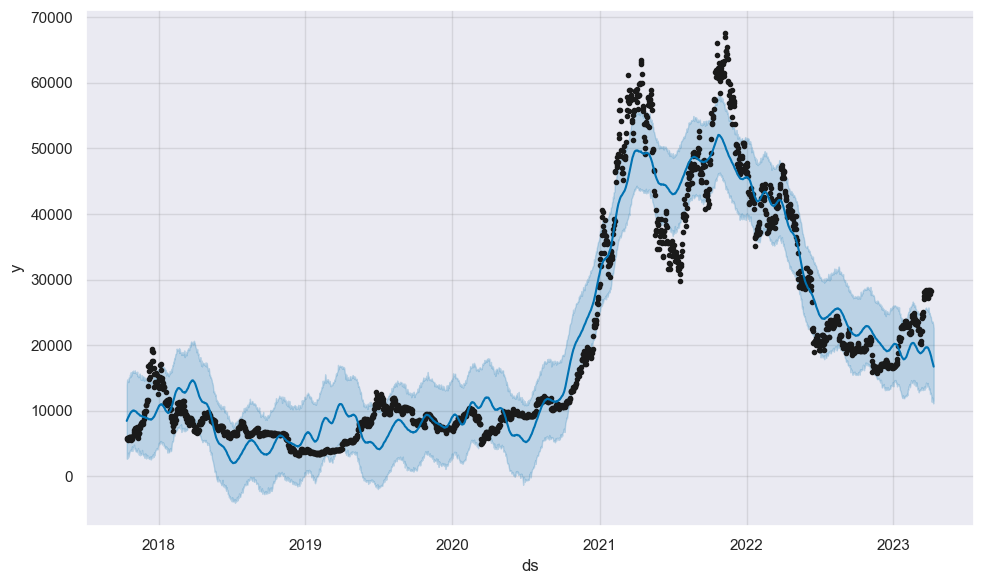

In [33]:
fig1 = model.plot(forecast)